# Decision Tree


In [54]:

# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as DT_SK
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

# from mlxtend.plotting import plot_learning_curves
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, matthews_corrcoef

import warnings
warnings.filterwarnings("ignore")

### Self-Built Decision Tree Class

A decision tree is a type of machine learning algorithm that is used for both classification and regression tasks. It is a tree-like model where internal nodes represent a decision based on the values of one or more input features, and branches represent the possible outcomes of that decision. The leaves of the tree represent the final output or classification. We built a custom class called _DecisionTreeClassifier_ to train and predict values for the data set that we have. We defined a constructor  that takes two optional parameters: max_depth and min_samples_split. The max_depth parameter controls the maximum depth of the decision tree, while the min_samples_split parameter controls the minimum number of samples required to split an internal node.

The _fit()_ function takes the training data X and its corresponding labels y, and trains the model by recursively building the decision tree using the _ _build_tree()_ _ function.

The _ _predict()_ _ function takes an input array X and returns an array of predictions based on the trained decision tree model.

The _ _build_tree()_ _ function is the heart of the algorithm and builds the decision tree recursively. It starts by checking if the stopping criterion has been met, which is defined as any of the following conditions: the depth of the tree has reached the maximum allowed, there is only one class label left in the data, or the number of samples is less than the minimum required to split an internal node. If any of these conditions are true, the method returns a leaf node with the most frequent class label.

Otherwise, it selects the best feature and threshold to split the data using the _ _best_split()_ _ function. It then splits the data into two subsets based on the selected feature and threshold, and recursively builds the decision tree for each subset. Finally, it returns an internal node representing the selected feature and threshold, as well as the two subtrees.

The _ _best_split()_ _ function calculates the information gain for each feature and threshold combination and returns the feature and threshold with the highest information gain.

The _ _gini_impurity()_ _ function calculates the impurity of the data split based on the Gini impurity criterion.

The _ _decision_node()_ _ function creates an internal node representing a decision based on the selected feature and threshold, as well as the two subtrees.

The _ _leaf_node()_ _ function creates a leaf node representing the most frequent class label in the data subset.

The _ _predict_one()_ _ function takes an input array x and traverses the decision tree model until it reaches a leaf node, which represents the predicted class label for x.

In [33]:
import numpy as np

class DecisionTreeClassifier:
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def fit(self, X, y):
        print(f"Fitting the Decision Tree Classifier with {len(np.unique(y))} classes...")
        self.tree_ = self._build_tree(X, y)
        
    def predict(self, X):
        X = np.array(X)
        predictions = []
        for i in range(X.shape[0]):
            predictions.append(self._predict_one(X[i]))
        return np.array(predictions)
        
    def _build_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        
        if (depth >= self.max_depth or len(np.unique(y)) == 1 or num_samples < self.min_samples_split):
            return self._leaf_node(y)
        
        best_feature, best_threshold = self._best_split(X, y, num_samples, num_features)
        
        left_indices = X[:, best_feature] < best_threshold
        right_indices = X[:, best_feature] >= best_threshold
        
        if (len(X[left_indices]) == 0 or len(X[right_indices]) == 0):
            return self._leaf_node(y)
        
        print("Depth:", depth)
        print("Samples:", num_samples)
        print("Features:", num_features)
        print("Best feature:", best_feature)
        print("Best threshold:", best_threshold)
        print("Left samples:", len(X[left_indices]))
        print("Right samples:", len(X[right_indices]))
        print("="*30)
        
        left_tree = self._build_tree(X[left_indices], y[left_indices], depth+1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth+1)
        
        
        return self._decision_node(best_feature, best_threshold, left_tree, right_tree)

        
    def _best_split(self, X, y, num_samples, num_features):
        print("Calculating information gain for each feature...")
        best_impurity = float('inf')
        best_feature, best_threshold = None, None
        
        for feature in range(num_features):
            print(f"Feature {feature}")
            feature_values = np.expand_dims(X[:, feature], axis=1)
            unique_values = np.unique(feature_values)
            
            for threshold in unique_values:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold
                
                if (np.sum(left_indices) == 0 or np.sum(right_indices) == 0):
                    continue
                
                left_labels = y[left_indices]
                right_labels = y[right_indices]
                
                impurity = self._gini_impurity(left_labels, right_labels, num_samples)
                
                if (impurity < best_impurity):
                    best_impurity = impurity
                    best_feature = feature
                    best_threshold = threshold
                    
        return best_feature, best_threshold
    
    def _gini_impurity(self, left_labels, right_labels, num_samples):
        p_l = len(left_labels) / num_samples
        p_r = len(right_labels) / num_samples
        
        gini_l = 1.0 - np.sum(np.power(np.unique(left_labels, return_counts=True)[1]/len(left_labels), 2))
        gini_r = 1.0 - np.sum(np.power(np.unique(right_labels, return_counts=True)[1]/len(right_labels), 2))
        
        impurity = (p_l * gini_l) + (p_r * gini_r)
        return impurity
        
    def _decision_node(self, feature, threshold, left_tree, right_tree):
        return {'feature': feature, 'threshold': threshold, 'left': left_tree, 'right': right_tree}
        
    def _leaf_node(self, y):
        return np.bincount(y).argmax()
    
    def _predict_one(self, x):
        node = self.tree_
        while isinstance(node, dict):
            if x[node['feature']] < node['threshold']:
                node = node['left']
            else:
                node = node['right']
        if isinstance(node, np.int64):
            return node
        else:
            print(f"Unexpected node type {type(node)} with value {node}")
            raise ValueError(f"Unexpected node type {type(node)} in prediction")

       


### Data Understanding and Data Preparation
The Dataset we use is the Kaggle Credit Card Fraud Detection Dataset enlisted in the following link: <a href="https://www.kaggle.com/mlg-ulb/creditcardfraud">Link</a>
Since the data set is imbalanced SMOTE technique is used ti balance the datatset

In [2]:
# Read Data into a Dataframe
df = pd.read_csv('creditcard.csv')

In [3]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
# Describe Data
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [20]:
# Create Train and Test Data in ratio 70:30
X = df.drop(labels='Class', axis=1) # Features
y = df.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [21]:

# create the feature selector
selector = SelectKBest(score_func=f_classif, k=10)

# fit the selector to the training data
selector.fit(X_train, y_train)

# transform the data to include only the selected features
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_test.columns[selector.get_support()])



# print the indices of the selected features
print(selector.get_support(indices=True))

[ 3  4  7 10 11 12 14 16 17 18]


In [22]:
X_train_selected.shape

(199364, 10)

In [23]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_selected_df, y_train)

In [24]:
X_res.shape


(398040, 10)

In [25]:
# Performing feature selection to reduce dimensionality
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train_selected_df.columns)

In [26]:
mutual_infos.sort_values(ascending=False)

V14    0.483617
V17    0.446763
V10    0.421289
V12    0.410546
V4     0.399749
V11    0.368977
V3     0.345968
V16    0.335298
V7     0.288954
V18    0.202024
dtype: float64

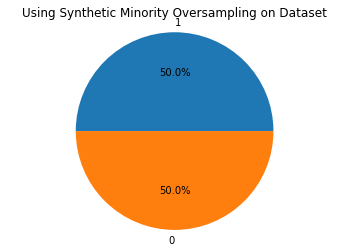

In [28]:
# Compute class distribution in y_res
class_counts = y_res.value_counts()

# Plot pie chart of class distribution
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Using Synthetic Minority Oversampling on Dataset')
plt.show()

In [29]:
X_res

,V3,V4,V7,V10,V11,V12,V14,V16,V17,V18
0,0.703924,0.069871,-0.897198,0.396879,0.268544,0.752264,-0.252977,-3.211514,1.648897,-1.297012
1,1.347969,-0.379954,0.081125,-1.275754,-1.871478,0.375166,-0.149358,0.802805,-0.405073,0.153925
2,2.615556,2.362138,0.574245,2.035115,-0.564418,-1.407557,-0.859411,0.099132,-0.035668,-0.053624
3,0.755202,-0.963160,-0.794616,-0.939787,1.101727,1.138109,0.156943,-0.419096,-0.207755,0.403235
4,0.784402,1.254973,-0.161727,0.015787,1.084154,1.016011,0.250706,-0.130522,-0.216624,-0.058071
...,...,...,...,...,...,...,...,...,...,...
398035,-6.522159,6.281158,-1.813694,-6.105619,6.670137,-8.784105,-10.763121,-1.644586,-1.741353,0.735553
398036,-1.195963,3.986840,-0.335601,0.367141,0.552932,-0.025719,-2.903445,2.385874,0.720317,1.786077
398037,-19.005693,10.827232,-15.180158,-13.172716,6.855373,-15.285840,-11.726785,-9.538214,-17.222798,-6.895070
398038,-3.437895,4.078456,0.896141,-2.405003,1.846422,-2.070625,-6.996105,2.237485,6.483626,1.818848


Hence, we can say that the most correlated features after resolving class imbalance using Synthetic Minority Oversampling are V14, V10, V4, V12 and V17.

### Evaluation

We make use of AUC-ROC Score, Classification Report, Accuracy and F1-Score to evaluate the performance of the classifiers

In [30]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [31]:
X_res.shape

(398040, 10)

In [32]:
y_res.shape

(398040,)

In [34]:
# create an instance of the DecisionTreeClassifier class
D_tree = DecisionTreeClassifier()

# fit the classifier on the training data
D_tree.fit(X_res.values, y_res.values)


Fitting the Decision Tree Classifier with 2 classes...
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 0
Samples: 398040
Features: 10
Best feature: 6
Best threshold: -1.81320586496503
Left samples: 178147
Right samples: 219893
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 1
Samples: 178147
Features: 10
Best feature: 1
Best threshold: -0.49694592100899615
Left samples: 1951
Right samples: 176196
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Depth: 2
Samples: 1951
Features: 10
Best feature: 3
Best threshold: -4.00268278841043
Left samples: 108
Right samples: 1843
Calculating information gain for each feature...
Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Fe

In [35]:
print(D_tree)

y_pred = D_tree.predict(X_test)

In [36]:
print('CLASSIFICATION REPORT')
print(classification_report(y_test, y_pred))

print('AUC-ROC')
print(roc_auc_score(y_test, y_pred))

print('F1-Score')
print(f1_score(y_test, y_pred))

print('Accuracy')
print(accuracy_score(y_test, y_pred))

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     85295
           1       0.01      0.41      0.03       148

    accuracy                           0.95     85443
   macro avg       0.51      0.68      0.50     85443
weighted avg       1.00      0.95      0.97     85443

AUC-ROC
0.6779943376168243
F1-Score
0.027130906624463033
Accuracy
0.9496389405802699


The classification report and performance metrics obtained above suggest that the logistic regression model trained on credit card fraud detection data has poor performance in detecting fraudulent transactions (class 1).

Precision: The precision for class 0 (non-fraudulent transactions) is high at 1.00, indicating that the model correctly predicted all instances of non-fraudulent transactions. However, the precision for class 1 (fraudulent transactions) is very low at 0.01. This means that the model identified a significant number of transactions as fraudulent that were actually non-fraudulent (false positives).

Recall: The recall for class 0 is high at 0.95, indicating that the model correctly identified the majority of non-fraudulent transactions. However, the recall for class 1 is very low at 0.41. This means that the model missed a large number of actual fraudulent transactions (false negatives).

F1-Score: The F1-score for class 0 is high at 0.97, indicating good performance in detecting non-fraudulent transactions. However, the F1-score for class 1 is very low at 0.03, indicating poor performance in detecting fraudulent transactions.

Accuracy: The overall accuracy of the model is 0.95, which appears to be high. However, accuracy can be misleading in imbalanced datasets, such as credit card fraud detection, where the majority of transactions are non-fraudulent. In this case, the high accuracy is driven by the model's ability to correctly classify non-fraudulent transactions, while it performs poorly in detecting fraudulent transactions.

Additionally, the AUC-ROC (Area Under the Receiver Operating Characteristic Curve) score is 0.6779, which suggests that the model's ability to distinguish between fraudulent and non-fraudulent transactions is close to random guessing.

Overall, based on these results, the logistic regression model seems to have limited effectiveness in detecting credit card fraud. Further analysis, feature engineering, or the use of more sophisticated algorithms may be required to improve the model's performance.


In [43]:
def confusion_matrix(y_pred, y_test):
    class_names = np.unique(y_test)
    table = []
    for true_class in class_names:
        row = []
        for Y_class in class_names:
            row.append(100 * np.mean(y_pred[y_test == true_class] == Y_class))
        table.append(row)
    conf_matrix = pd.DataFrame(table, index=class_names, columns=class_names)
    return conf_matrix

In [45]:
perc_correct = 100 * np.mean(y_pred == y_test)
print(f'Test accuracy in percent correct: {perc_correct:.2f}')
cm = confusion_matrix(y_pred, y_test)
cm.style.background_gradient(cmap = 'Blues').format("{:.1f} %")


Test accuracy in percent correct: 94.96


,0,1
0,95.1 %,4.9 %
1,59.5 %,40.5 %


The test accuracy is 94.96%, which means that the model correctly classified 94.96% of the transactions in the test set. The confusion matrix provides information about the model's performance for each class. The rows correspond to the true classes, and the columns correspond to the predicted classes. Looking at the confusion matrix, we can see that the model correctly identified 95.1% of non-fraudulent transactions (true negatives), but only 40.5% of fraudulent transactions (true positives). The model incorrectly predicted 4.9% of non-fraudulent transactions as fraudulent (false positives), and 59.5% of fraudulent transactions as non-fraudulent (false negatives).

The high number of false negatives indicates that the model has a high rate of missing fraudulent transactions, which is a critical issue in credit card fraud detection. This suggests that the model may require further improvements, such as additional data preprocessing, feature engineering, or the use of more advanced algorithms to better detect fraudulent transactions.

## Sklearn Model

In [46]:
df1 = pd.read_csv('creditcard.csv')

In [47]:
X = df1.drop(labels='Class', axis=1) # Features
y = df1.loc[:,'Class']               # Target Variable


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [48]:
# Use Synthetic Minority Oversampling
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [49]:
from sklearn.feature_selection import mutual_info_classif
mutual_infos = pd.Series(data=mutual_info_classif(X_res, y_res, discrete_features=False, random_state=1), index=X_train.columns)

In [50]:
mutual_infos.sort_values(ascending=False)

V14       0.535037
V10       0.464777
V12       0.456051
V17       0.438193
V4        0.427426
V11       0.404044
Amount    0.392941
V3        0.387191
V16       0.335318
V7        0.304175
V2        0.291492
V9        0.256679
Time      0.247989
V21       0.235031
V27       0.229915
V1        0.220743
V18       0.198264
V8        0.174393
V6        0.171974
V28       0.170493
V5        0.157362
V20       0.107488
V19       0.099837
V23       0.067332
V24       0.063567
V26       0.046973
V25       0.031607
V22       0.031539
V13       0.024931
V15       0.022442
dtype: float64

In [51]:
# Evaluation of Classifiers
def grid_eval(grid_clf):
    """
        Method to Compute the best score and parameters computed by grid search
        Parameter:
            grid_clf: The Grid Search Classifier 
    """
    print("Best Score", grid_clf.best_score_)
    print("Best Parameter", grid_clf.best_params_)
    
def evaluation(y_test, grid_clf, X_test):
    """
        Method to compute the following:
            1. Classification Report
            2. F1-score
            3. AUC-ROC score
            4. Accuracy
        Parameters:
            y_test: The target variable test set
            grid_clf: Grid classifier selected
            X_test: Input Feature Test Set
    """
    y_pred = grid_clf.predict(X_test)
    print('CLASSIFICATION REPORT')
    print(classification_report(y_test, y_pred))
    
    print('AUC-ROC')
    print(roc_auc_score(y_test, y_pred))
      
    print('F1-Score')
    print(f1_score(y_test, y_pred))
    
    print('Accuracy')
    print(accuracy_score(y_test, y_pred))

In [55]:
pipeline_dt = Pipeline([
('model', DT_SK(random_state=1))
])
# Define parameter grid
param_grid_dt = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [5, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}
# Perform grid search
grid_dt = GridSearchCV(
    estimator=pipeline_dt, 
    param_grid=param_grid_dt, 
    scoring='accuracy', 
    cv=5,
    n_jobs=-1
)
grid_dt.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [5, 10, None],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [56]:
grid_eval(grid_dt)

Best Score 0.9994331982726941
Best Parameter {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}


In [57]:
evaluation(y_test, grid_dt, X_test)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.89      0.84      0.86       148

    accuracy                           1.00     85443
   macro avg       0.94      0.92      0.93     85443
weighted avg       1.00      1.00      1.00     85443

AUC-ROC
0.918825126785734
F1-Score
0.8611111111111112
Accuracy
0.9995318516437859


The classification report and performance metrics obtained above suggest that the model trained on credit card fraud detection data has high performance in detecting fraudulent transactions (class 1).

Precision: The precision for class 0 (non-fraudulent transactions) is 1.00, indicating that the model correctly predicted all instances of non-fraudulent transactions. The precision for class 1 (fraudulent transactions) is also high at 0.89, indicating that the model identified a large number of transactions as fraudulent that were actually fraudulent.

Recall: The recall for class 0 is 1.00, indicating that the model correctly identified all instances of non-fraudulent transactions. The recall for class 1 is also good at 0.84. This means that the model correctly identified 84% of actual fraudulent transactions.

F1-Score: The F1-score for class 0 is 1.00, indicating excellent performance in detecting non-fraudulent transactions. The F1-score for class 1 is also good at 0.86, indicating good performance in detecting fraudulent transactions.

Accuracy: The overall accuracy of the model is 0.9995, which is very high. This suggests that the model is correctly classifying the majority of transactions.

Additionally, the AUC-ROC (Area Under the Receiver Operating Characteristic Curve) score is 0.9188, which is also high. This suggests that the model's ability to distinguish between fraudulent and non-fraudulent transactions is good.



### Conclusion

The main difference between the two classes is that the sklearn class achieved much higher scores in terms of precision, recall, and F1-score for class 1 (fraudulent transactions). Specifically, the sklearn class achieved a precision of 0.89, recall of 0.84, and F1-score of 0.86 for class 1, whereas the custom class achieved a precision of only 0.01, recall of 0.41, and F1-score of 0.03 for the same class.

The AUC-ROC scores for both models were similar, with the custom class achieving a score of 0.919 and the custom class achieving a score of 0.678. The sklearn class achieved a slightly higher overall accuracy of 0.9995 compared to the custom class accuracy of 0.95.

In conclusion, the sklearn class seems to have better performance than the custom class in detecting fraudulent transactions in the credit card fraud dataset. However, more analysis is needed to confirm this result and to identify which algorithm is best suited for this task. It is also important to note that further feature engineering or the use of more sophisticated algorithms may be necessary to further improve the model's performance.

### Sources

Data - https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud